In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
data = pd.read_csv('/content/drive/MyDrive/train.csv')

In [66]:
def convert_doors(x):
  if x=='04-May':
    return 4
  elif x == '02-Mar':
    return 2
  elif x=='>5':
    return 5

data = data.drop(['ID','Cylinders','Mileage'],axis=1)
data = data.drop(data.Price[data.Price > 400000].index,axis=0)


data.Doors = data.Doors.apply(convert_doors)
# data.Mileage = data.Mileage.apply(lambda x : int(x.strip('km').strip()))
data['Isturbo'] =  data['Engine volume'].apply(lambda x: 1 if 'Turbo' in x else 0)
# data['Levy'] = data['Levy'].apply(lambda x: 0 if '-' in x else int(x))
data['Engine volume'] = data['Engine volume'].apply(lambda x : 6 if (float(x.strip('Turbo').strip())) > 5 else float(x.strip('Turbo').strip()))


In [503]:
# for col in data.select_dtypes('object'):
#   print(col , data[col].unique())

In [25]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df

In [505]:
# data[(data['Manufacturer']=='MAZDA') & (data['Model']== '1000')].Price

In [67]:

data = data.drop(data[(data['Price'] > 175000) | (data['Price'] < 100)].index, axis=0)

In [68]:

data['Levy'] = data['Levy'].apply(lambda x: np.nan if '-' in x else int(x))
data = imputation(data,list(data.select_dtypes('object').columns))


data.Price = np.log(data.Price)
data.Levy = np.log(data.Levy)

In [470]:
# len(data[data['Doors'] == 5])

In [467]:
# sns.distplot(data['Airbags'])

In [469]:
# sns.distplot(np.log(data.Airbags))

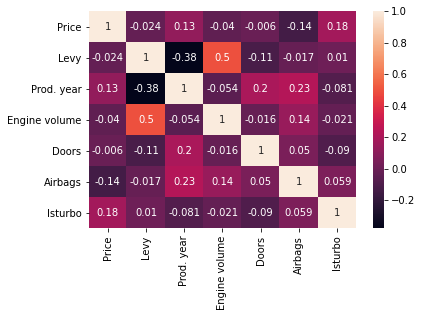

In [28]:
sns.heatmap(data.corr(),annot=True)

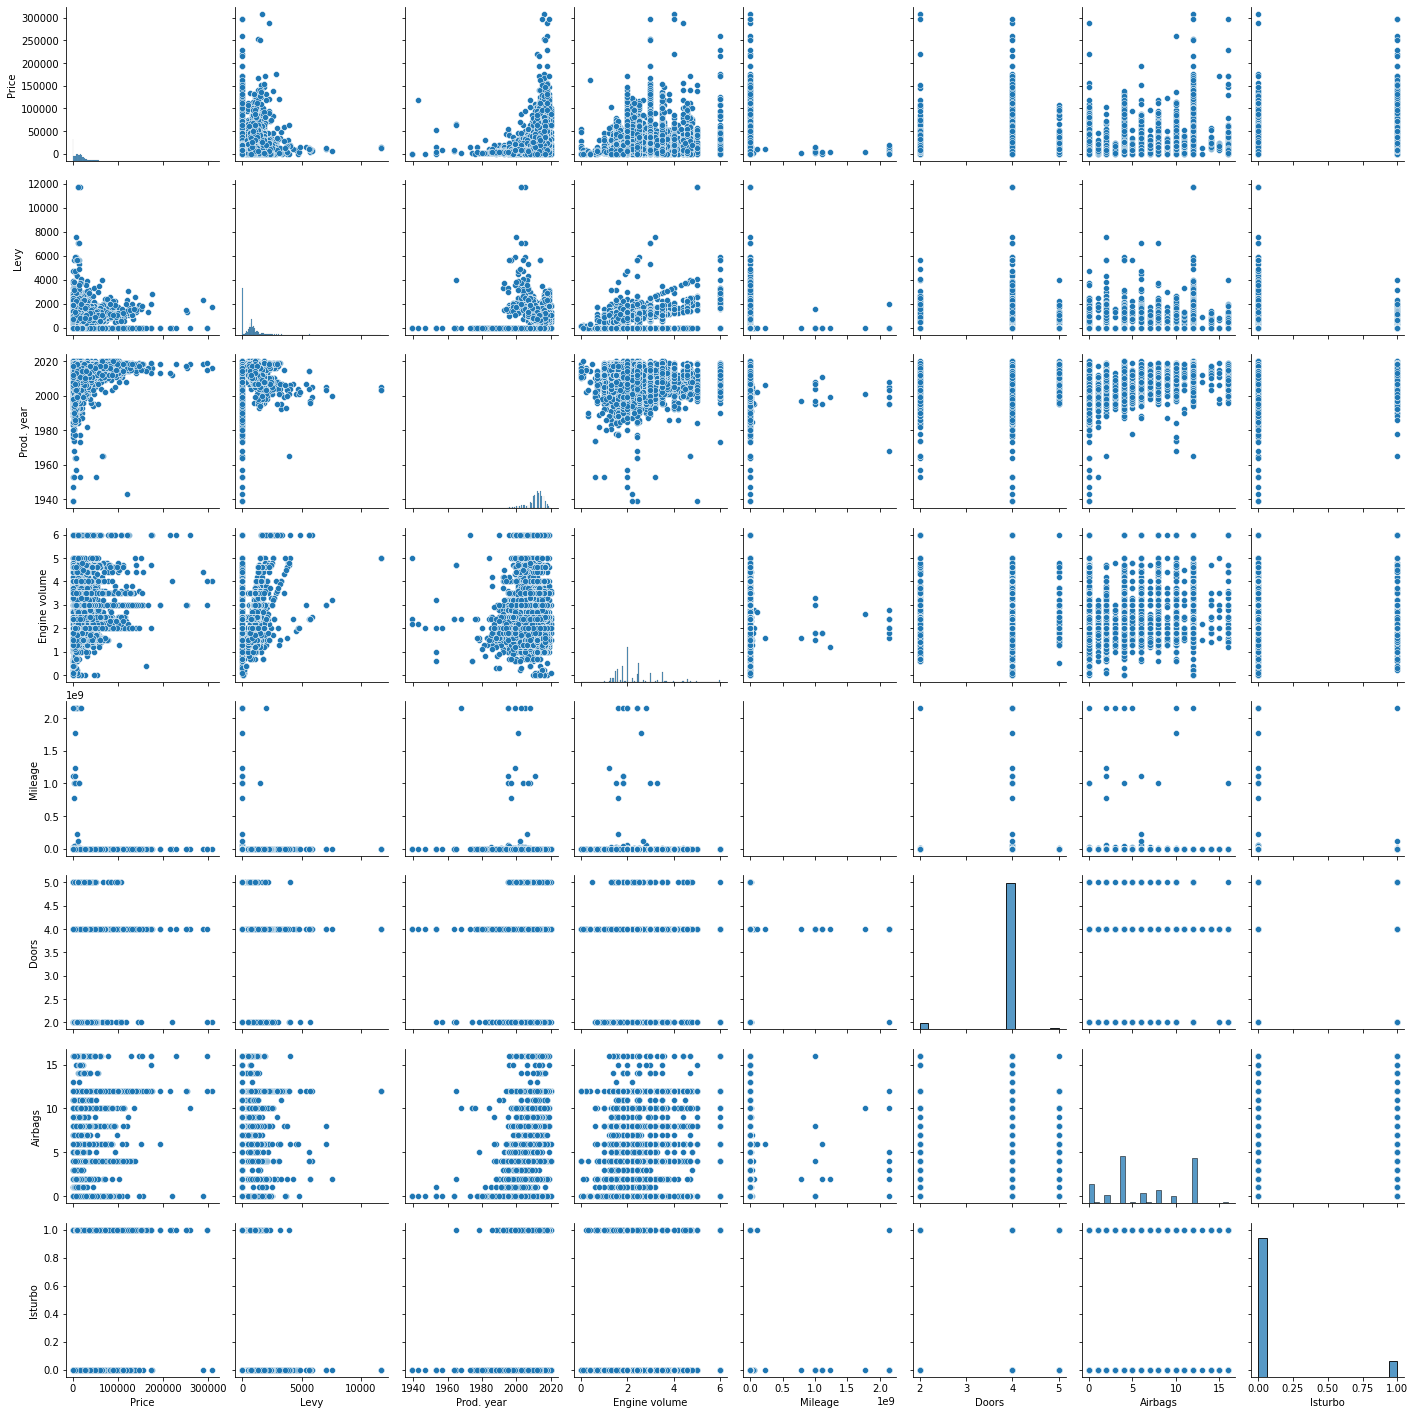

In [107]:
sns.pairplot(data)

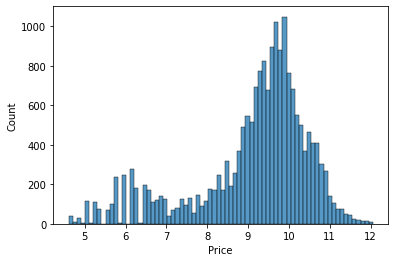

In [29]:
sns.histplot(data['Price'])

In [69]:
gf = data.groupby(['Model','Manufacturer']).count()['Price']
gf = (gf[gf>3]).reset_index()
len(gf)

376

In [70]:
for g in range(len(gf)):
  val = data[(data['Manufacturer']==gf['Manufacturer'][g]) & (data['Model']==gf['Model'][g])].Price.mean()
  data.loc[(data['Manufacturer']==gf['Manufacturer'][g]) & (data['Model']==gf['Model'][g]) & (data['Price'] > val*3),'Price'] = val

In [489]:
# data = data.drop(data[(data['Price'] > 175000) | (data['Price'] < 100)].index, axis=0)

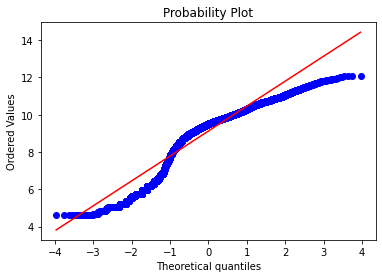

In [71]:

from scipy import stats
fig = plt.figure()
res = stats.probplot(data['Price'], plot=plt)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


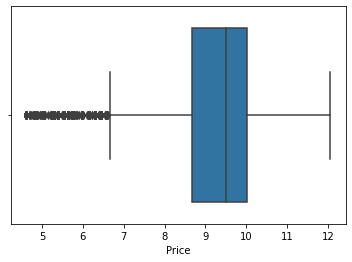

In [33]:
sns.boxplot(data['Price'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


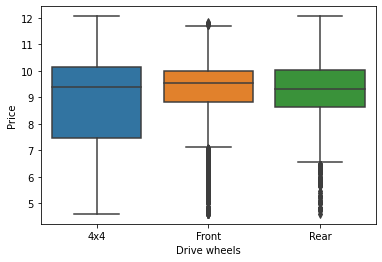

In [517]:
sns.boxplot(data['Drive wheels'] ,data['Price'])

In [34]:
import scipy.stats as ss

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum() 
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

col_list = [data.columns[i] for i in np.where(data.dtypes == 'object')[0]]
kk=[]
for i in col_list:
  for j in col_list:
    confusion_matrix = pd.crosstab(data[i],data[j])
    kk.append((cramers_v(confusion_matrix.values),i,j))
for i in kk:
  if i[0] >0.5 and i[1] != i[2]:
    print(i)

(0.9477340686510246, 'Manufacturer', 'Model')
(0.6134351293328698, 'Manufacturer', 'Drive wheels')
(0.9477340686510245, 'Model', 'Manufacturer')
(0.7217741245201914, 'Model', 'Category')
(0.6484311732159352, 'Model', 'Leather interior')
(0.5974743642000394, 'Model', 'Fuel type')
(0.5818028030156154, 'Model', 'Gear box type')
(0.8201074706013043, 'Model', 'Drive wheels')
(0.7197815616778143, 'Model', 'Wheel')
(0.7217741245201914, 'Category', 'Model')
(0.6484311732159354, 'Leather interior', 'Model')
(0.5974743642000394, 'Fuel type', 'Model')
(0.5818028030156154, 'Gear box type', 'Model')
(0.6134351293328698, 'Drive wheels', 'Manufacturer')
(0.8201074706013043, 'Drive wheels', 'Model')
(0.7197815616778143, 'Wheel', 'Model')


In [72]:
data = data.drop(['Drive wheels'], axis=1)

In [82]:
df = data.copy()
X = df.drop(['Price'],axis=1)
y = df['Price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
!pip install catboost

In [83]:
cat_features = np.where(X.dtypes == 'object')[0]
from catboost import CatBoostRegressor,Pool
reg = CatBoostRegressor(loss_function='RMSE',verbose=0)
reg.fit(X,y,cat_features=cat_features,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [84]:
from sklearn.metrics import mean_squared_log_error
pred = reg.predict(X_test)
y_test = list(map(lambda x: x*(-1) if x<0 else x,list(y_test)))
pred = list(map(lambda x: x*(-1) if x<0 else x,list(pred)))
print(mean_squared_log_error(pred,y_test))

0.008381246111774283


0.008253591989521825


0.9390016385896823


In [95]:
df = data.copy()
obj_feat = list(df.loc[:, df.dtypes == 'object'].columns.values)
for feature in obj_feat:
    df[feature] = pd.Series(df[feature], dtype="category")
X = df.drop(['Price'],axis=1)
y = df['Price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [97]:
import lightgbm as lgb
hyper_params = {
    'task': 'train',
    'objective': 'regression'
}
lgb_train = lgb.Dataset(X, y)
gbm = lgb.train(hyper_params, lgb_train, num_boost_round=100)

In [98]:
from sklearn.metrics import mean_squared_log_error
pred = gbm.predict(X_test)
y_test = list(map(lambda x: x*(-1) if x<0 else x,list(y_test)))
pred = list(map(lambda x: x*(-1) if x<0 else x,list(pred)))
print(mean_squared_log_error(pred,y_test))

0.007999715395297575


In [85]:
data2 = pd.read_csv('/content/drive/MyDrive/test.csv')

data2 = data2.drop(['ID','Cylinders','Mileage','Price'],axis=1)

data2.Doors = data2.Doors.apply(convert_doors)
data2['Isturbo'] =  data2['Engine volume'].apply(lambda x: 1 if 'Turbo' in x else 0)
data2['Engine volume'] = data2['Engine volume'].apply(lambda x : 6 if (float(x.strip('Turbo').strip())) > 5 else float(x.strip('Turbo').strip()))


In [88]:
data2 = data2.drop(['Drive wheels'], axis=1)

In [86]:
data2['Levy'] = data2['Levy'].apply(lambda x: np.nan if '-' in x else int(x))
data2 = imputation(data2,list(data2.select_dtypes('object').columns))
data2.Levy = np.log(data2.Levy)

In [100]:
obj_feat1 = list(data2.loc[:, data2.dtypes == 'object'].columns.values)
for feature in obj_feat1:
    data2[feature] = pd.Series(data2[feature], dtype="category")

In [101]:
pred = gbm.predict(data2)
pred = np.exp(pred)

In [105]:

pred1 = gbm.predict(data2)
pred2 = reg.predict(data2)
pred = (pred1 + pred2)/2
pred = np.exp(pred)

In [106]:
result = pd.DataFrame(pred ,columns=['Price'])
result.head()

,Price
0,15696.686276
1,16436.171685
2,7291.885980
3,1882.862864
4,4045.667408


In [107]:
result[result.Price<0]

,Price


In [327]:
# result.Price = result.Price.apply(lambda x: -1*x if x<0 else x)

In [109]:
result.to_csv('result8.csv',index=False)